# Variational GPs w/ Multiple Outputs

## Introduction

In this example, we will demonstrate how to construct approximate/variational GPs that can model vector-valued functions (e.g. multitask/multi-output GPs).


In [1]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [8]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * (2 * math.pi)) + 2 * torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -torch.sin(train_x * (2 * math.pi)) + 1.3 * torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.randn(train_x.size()) * 0.2,
    2 - torch.sin(train_x * (2 * math.pi)) torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

SyntaxError: invalid syntax (<ipython-input-8-21218e93542f>, line 10)

## Define a multitask model

This model should look like a combination of the [SVGP regression example](./SVGP_Regression_CUDA.ipynb) and the [batch independent multitask GP example](../03_Multitask_Exact_GPs/Batch_Independent_Multioutput_GP.ipynb).

We are going to construct a batch variational GP - using a `CholeskyVariationalDistribution` and a `VariationalStrategy`. Each of the batch dimensions is going to correspond to one of the outputs. In addition, we will wrap the variational strategy to make the output appear as a `MultitaskMultivariateNormal` distribution. Here are the changes that we'll need to make:

1. Our inducing points will need to have shape `2 x m x 1` (where `m` is the number of inducing points). This ensures that we learn a different set of inducing points for each output dimension.
1. The `CholeskyVariationalDistribution`, mean module, and covariance modules will all need to include a `batch_shape=torch.Size([2])` argument. This ensures that we learn a different set of variational parameters and hyperparameters for each output dimension.
1. The `VariationalStrategy` object should be wrapped in a `~gpytorch.variational.MultitaskVariationalStrategy`. This converts the output from a batch MultivariateNormal distribution into a MultitaskMultivariateNormal distribution. This makes it possible to use multitask likelihooods (e.g. `~gpytorch.likelihoods.MultitaskGaussianLikelihood`, `~gpytorch.likelihoods.SoftmaxLikelihood`, etc.) with this model.

In [3]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_tasks=4, num_functions=3, num_groups=2):
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_functions, num_groups])
        )
        print(variational_distribution.batch_shape)
        
        # We have to wrap the VariationalStrategy in a MultitaskVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.BatchLCMVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=num_tasks, num_functions=num_functions, num_groups=num_groups,
            group_dim=1, function_dim=0,
        )
        
        super().__init__(variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_groups]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_groups])),
            batch_shape=torch.Size([num_groups])
        )
        
    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# The shape of the inducing points should be (2 x m x 1) - so that we learn different inducing
# points for each output
num_groups = 2
num_functions = 3
num_tasks = 4
inducing_points = torch.rand(num_groups, 16, 1)
model = MultitaskGPModel(inducing_points, num_tasks=num_tasks, num_functions=num_functions, num_groups=num_groups)

# We're going to use a multitask likeihood with this model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

torch.Size([3, 2])


With all of the `batch_shape` arguments - it may look like we're learning a batch of GPs. However, the `MultitaskVariationalStrategy` object converts this into a (non-batch) MultitaskMultivariateNormal, where each of the tasks represents an output.

### Train the model

This code should look similar to the SVGP training code

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 500


model.train()
likelihood.train()

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

### Make predictions with the model

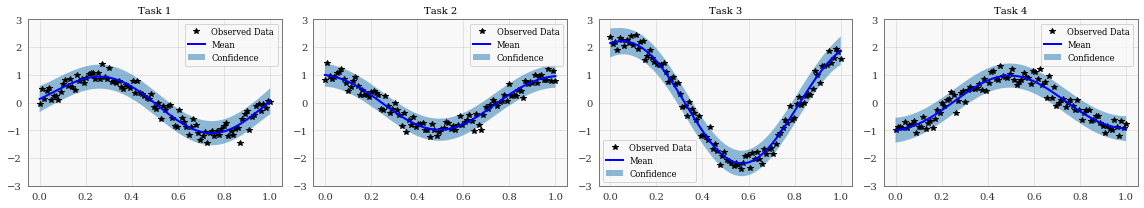

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
for task, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, task].numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None